In [34]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
import time
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore', category=FutureWarning)

Dieses Jupyter Notebook modelliert den Stromverbrauch Deutschlands mit der Berücksichtigung von EM und WM Einflüssen mit machine Learning Modellen und ist in drei große Teile unterteilt:
- 1. Preprocessing
- 2. Feature Engineering
- 3. Modellierung

Diese Schritte werden aufeinanderfolgend durchgeführt. Jeder Teil bezieht dabei Funktionen aus weiteren Jupyter Notebooks aus diesem Repository und werden am Anfang jedes Teils geladen

# 1. Preprocessing

In [72]:
%run Preprocessing.ipynb

Im Zug des Preprocessings werden Klimadaten, Fußballdaten und Stromverbrauchsdaten importiert. Anschließend werden alle Dataframes zusammengefügt und dem Feature Engineering übergeben

## 1.1 Klimadaten
- Hier werden historische Klimadaten des deutschen Wetterdienstes zu Temperatur und Niederschlag importiert
- Anschließend werde diese von 10min Schritte auf 15min Schritten gesampled
- aufgrund der großen Datenmenge kann diese bis zu 10min in Anspruch nehmen

### 1.1.1 Klimadaten - Import 

In [73]:
# Definiere die Arten von Klimadaten und die Stationen
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]

# Bestimme das aktuelle Arbeitsverzeichnis
current_directory = os.getcwd()

# Definiere den Pfad zu den Wetterdaten
temp_path = rf"{current_directory}\Wetter"

# Definiere das Dateimuster und die Spalte für das Datum
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

# Initialisiere eine Liste für die Klimadaten der Stationen
station_climate_list = []

# Durchlaufe jede Station und jede Art von Klimadaten
for station in station_names:
    for data in climate_data:
        # Erstelle den Pfad zur Datei für die jeweilige Station und Art von Klimadaten
        file_path = rf"{temp_path}\{station}\{data}"

        # Importiere die Klimadaten
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)  # Optional: Ausgabe der importierten Daten zur Kontrolle
        
        # Füge die importierten Daten der Liste hinzu
        station_climate_list.append(temperature_dic)

# Ausgabe, wenn der Import abgeschlossen ist
print("done")


done


### 1.1.2 Klimadaten - Downsampling auf 15min Schritten

In [74]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)


print("done")

done


## 1.2 Football Data
- Fußballdaten werden erst importiert
- anschließend werden Spiele, welche zur selben Zeit stattfinden einer neuen Spalte zugeordnet

### 1.2.1 Fußballdaten - Import

In [75]:
# Definiere den Pfad zu den Fußballspiel-Daten
temp_path = r"Spielplan"

# Definiere das Dateimuster für die CSV-Dateien
file_name = "*.csv"

# Definiere die Spalte für das Datum und das Datumsformat
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

# Importiere die Fußballspieldaten
football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

# Ausgabe, wenn der Import abgeschlossen ist
print("done")


done


### 1.2.2 Fußballdaten - Neue Spalten für Spiele

In [81]:
# Erstelle ein leeres Dictionary für die neuen Fußballspieldaten
football_dic_new = {}

# Durchlaufe jedes Jahr und die zugehörigen Spieldaten im ursprünglichen Dictionary
for key, match_set in football_dic.items():

    # Wende die Funktion an, um die Spieldaten zu bereinigen und zu ergänzen
    results = new_col_match(match_set)        

    # Setze die "DateTime"-Spalte als Index (beachte, dass diese Zeile die Daten nicht direkt im DataFrame ändert)
    results.set_index("DateTime")
    
    # Speichere die bearbeiteten Daten im neuen Dictionary
    football_dic_new[key] = results

# Ausgabe, wenn die Verarbeitung abgeschlossen ist
print("done")


done


## 1.3 Stromverbrauchsdaten
- importieren der Stromverbrauchsdaten
- Umwandlung der Werte in Floats

In [82]:
# Definiere den Pfad zu den Stromverbrauch-Daten
temp_path = r"Stromverbrauch\Viertel"

# Definiere das Dateimuster für die CSV-Dateien
file_name = "*.csv"

# Definiere die Spalte für das Datum und das Datumsformat
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

# Importiere die Stromverbrauchsdaten
elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)

# Ausgabe, wenn der Import abgeschlossen ist
print("done")


done


## 1.4 Zusammenfügen der Daten
- Vernachlässigung unnötiger Spalten
- auffüllen der NaNs

In [83]:
# Erstelle eine leere Liste, um die zusammengeführten DataFrames zu speichern
dfs = []

# Definiere eine Liste von unerwünschten Spaltennamen
unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)  # Optional: Ausgabe der Resampled-Klimadaten zur Kontrolle

# Durchlaufe jedes Jahr und die zugehörigen Stromverbrauchsdaten im Dictionary
for key, elec in elec_dic.items():
    # Hole die zugehörigen Fußballspieldaten für das aktuelle Jahr
    football = football_dic_new[key]
    
    # Hole die Stromverbrauchsdaten für das aktuelle Jahr
    electricity = elec
    
    # Erstelle eine Liste der Klimadaten-DataFrames für das aktuelle Jahr
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    # Führe die Daten für Stromverbrauch, Fußballspiele und Klimadaten zusammen
    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    # Füge den zusammengeführten DataFrame der Liste hinzu
    dfs.append(merged_df)

# Füge alle DataFrames in der Liste zu einem einzigen DataFrame zusammen
endresult_df = pd.concat(dfs, ignore_index = True)

# Ausgabe, wenn die Zusammenführung abgeschlossen ist
print("done")


done


# 2. Feature Engineering

In [84]:
%run feature_engineering.ipynb

Das Feature Engineering soll relevante Feature extrahieren und die Daten für Machine Learning Modelle verwertbar machen:
- es wird mit Korrelationsmatrizen gearbeitet
- ausgewählte Daten werden encoded
- weitere Feature werden aus den Datetime Objekten extrahiert
- die Daten werden normiert

## 2.1 Korrelationsmatrix

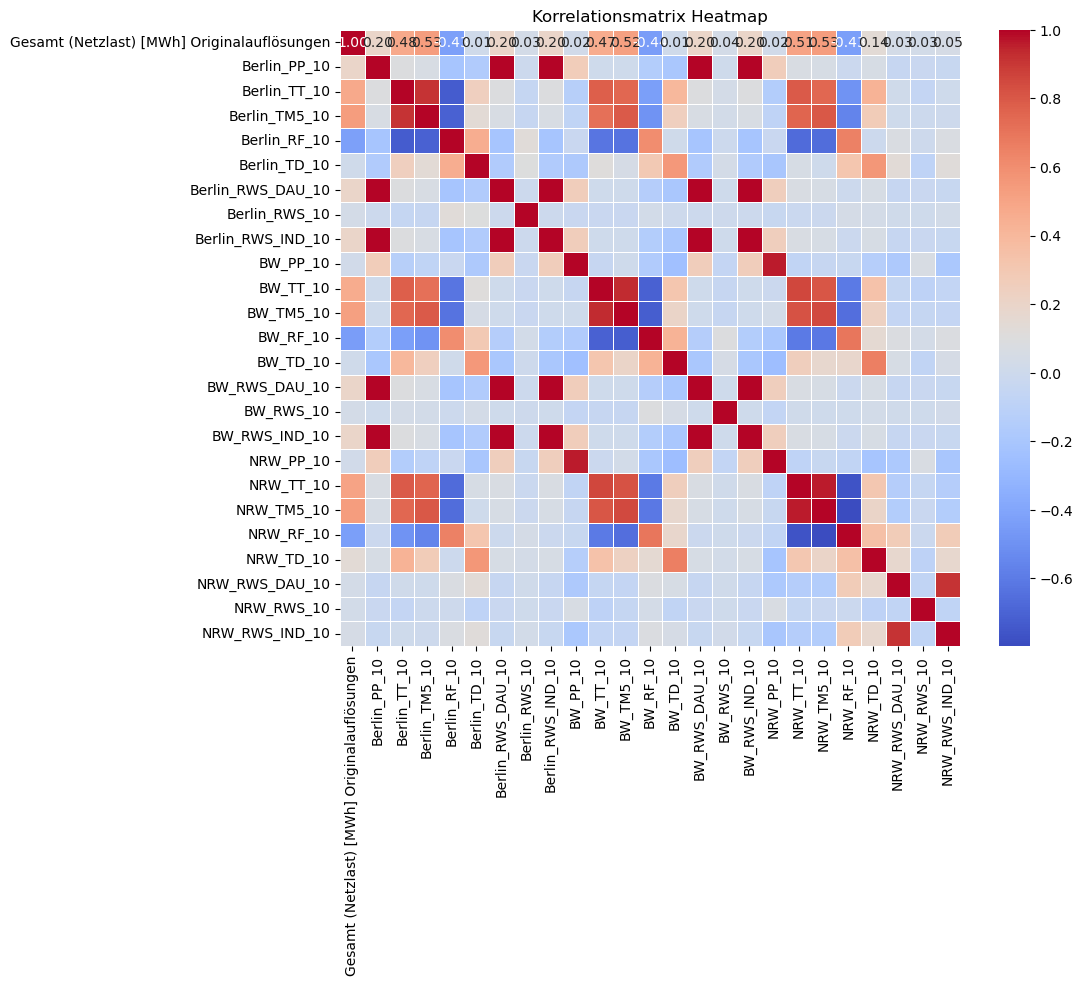

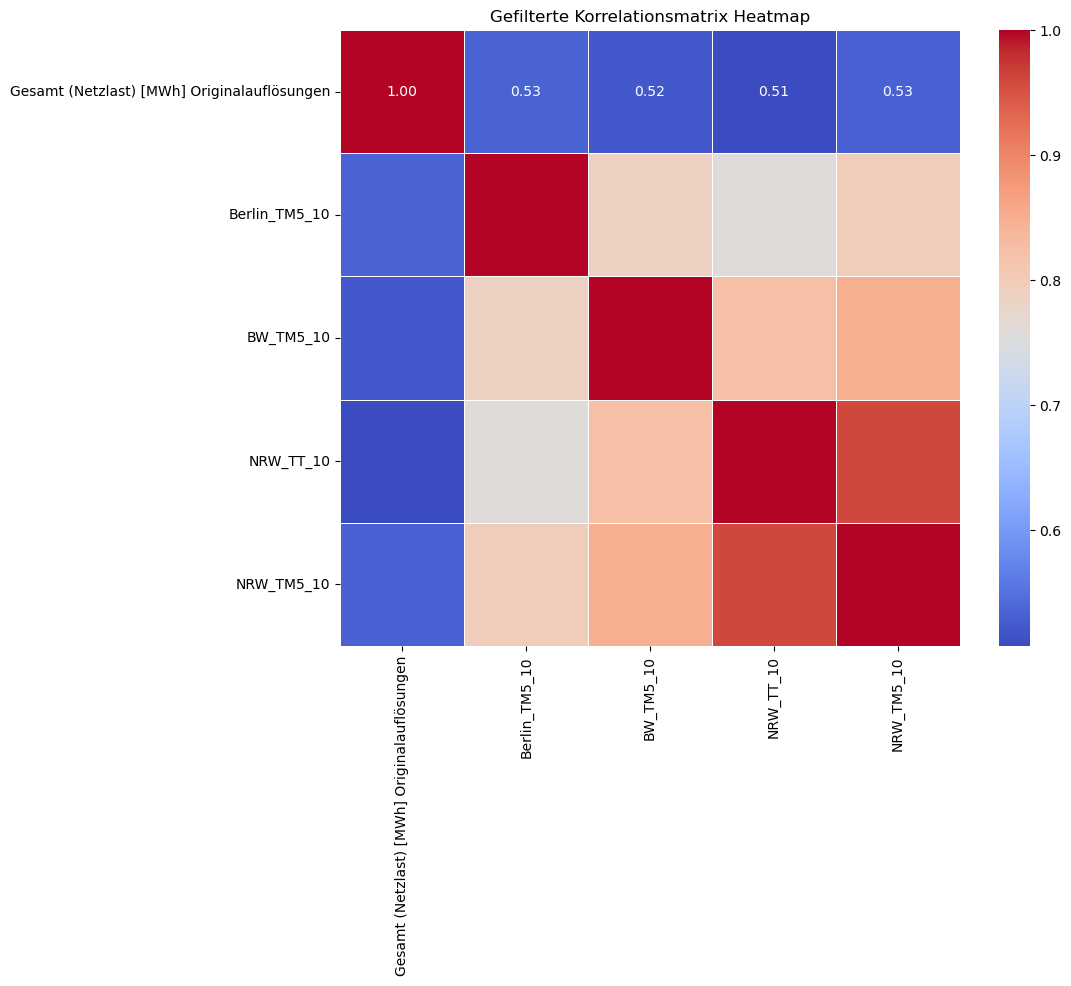

done


In [85]:
# Definiere die Namen der kategorischen Spalten
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

# Definiere den Schwellenwert für die Korrelation
cut_off_limit = 0.5

# Erstelle eine Kopie des DataFrames für die Korrelation
corr_df_input = endresult_df.copy()

# Berechne und filtere die Korrelationen und speichere das Ergebnis in df_filtered
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)

# Ausgabe, wenn die Berechnung abgeschlossen ist
print("done")


## 2.2 Reduzierung der Dimension

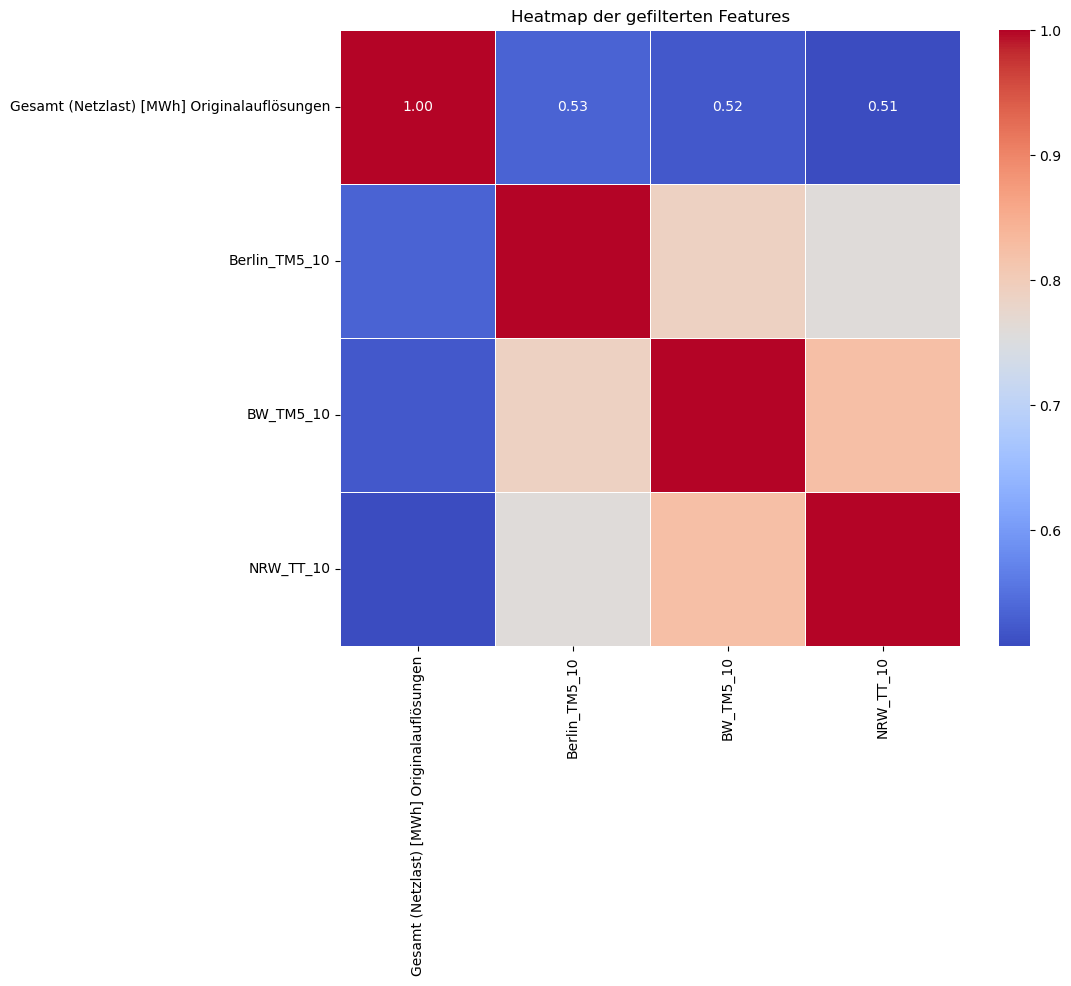

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                         11930.50 2016-06-10 00:00:00   
1                                         11764.50 2016-06-10 00:15:00   
2                                         11602.50 2016-06-10 00:30:00   
3                                         11495.00 2016-06-10 00:45:00   
4                                         11384.25 2016-06-10 01:00:00   
...                                            ...                 ...   
12187                                     11220.50 2024-07-14 22:45:00   
12188                                     11049.50 2024-07-14 23:00:00   
12189                                     10986.00 2024-07-14 23:15:00   
12190                                     10838.75 2024-07-14 23:30:00   
12191                                     10626.50 2024-07-14 23:45:00   

         Land1    Land2   Runde Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  \
0          NaN      NaN     NaN  

In [86]:
# Setze den Schwellenwert für die Korrelation
correlation_threshold = 0.9  # Passe diesen Schwellenwert nach Bedarf an

# Definiere die Namen der kategorischen Spalten
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

# Erstelle eine Kopie des gefilterten DataFrames für die Dimensionsreduktion
reduce_input_df = df_filtered.copy()

# Führe die Dimensionsreduktion durch und speichere das Ergebnis in df_reduced
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold, categorical_columns)

# Ausgabe, wenn die Dimensionsreduktion abgeschlossen ist
print("done")


## 2.3 Normierung

In [87]:
# Definiere die Namen der kategorischen Spalten
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

# Bestimme die Spalten, die normalisiert werden sollen (nicht kategorisch)
columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]

# Erstelle einen MinMaxScaler
scaler = MinMaxScaler()

# Erstelle eine Kopie des reduzierten DataFrames für die Normalisierung
df_normalized = df_reduced.copy()

# Skaliere die ausgewählten Spalten auf den Bereich [0, 1]
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

# Ausgabe, wenn die Normalisierung abgeschlossen ist
print("done")


done



## 2.4 Extrahieren von Features aus Datetime

In [88]:
# Erstelle eine Kopie des normalisierten DataFrames für die Zeitmerkmale
df_time_feature = df_normalized.copy()

# Extrahiere Jahr, Monat, Tag, Stunde, Minute, Wochentag und Kalenderwoche aus der Datetime-Spalte
df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week
df_time_feature['is_weekend'] = df_time_feature['DateTime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Filtere die Daten für das Jahr 2024 heraus
df_2024_datetime = df_time_feature[df_time_feature['year'] == 2024]
df_2024_datetime = df_2024_datetime["DateTime"]

# Entferne die ursprüngliche DateTime-Spalte, wenn sie nicht mehr benötigt wird
df_time_feature.drop(columns=["DateTime"], inplace=True)

# Ausgabe, wenn die Verarbeitung abgeschlossen ist
print("done")


done


## 2.5 Encodierung

### 2.5.1 One-Hot Encoding

In [89]:
# Erstelle eine Kopie des DataFrames für die One-Hot-Kodierung
hot_encoded_df = df_time_feature.copy()

# Definiere die kategorischen Spalten, die one-hot kodiert werden sollen
categorical_columns = ["Runde", "Liga"]

# Führe die One-Hot-Kodierung für die angegebenen kategorischen Spalten durch
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns=categorical_columns)

# Ausgabe, wenn die Verarbeitung abgeschlossen ist
print("done")


done


### 2.5.2 Ordinal Encoding

In [90]:
# Definiere den Pfad und die Dateinamen für die Importfunktion der Fußball-Daten
temp_path = r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

# Importiere die Fußball-Daten
football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

# Bestimme das Ranking der Länder nach Einschaltquoten
country_to_rank = ranking_countries_by_viewership(football_dic_copy)

# Definiere die Spalten, die ordinal kodiert werden sollen
encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

# Erstelle eine Kopie des DataFrames für die Ordinal-Kodierung
ordinal_encoded_df = hot_encoded_df.copy()

# Wende die Ordinal-Kodierung auf die definierten Spalten an
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
# Zeige die Spaltennamen des kodierten DataFrames
print(ordinal_encoded_df.columns)

# Entferne die ursprünglichen Spalten und behalte nur die kodierten Spalten
df_encoded = ordinal_encoded_df.drop(columns=encoding_columns)

# Zeige die Anzahl der verbleibenden Spalten
print(len(df_encoded.columns))

# Filtere den DataFrame für das Jahr 2024
df_2024 = df_encoded[df_encoded['year'] == 2024]

# Definiere den Abweichungsfaktor für das Hinzufügen von Gaußschen Rauschen
deviation_factor = 0.05  # 5% Abweichung

df_not_2024 = df_encoded[df_encoded['year'] != 2024]

# Zeige die Spaltennamen des DataFrames, der nicht das Jahr 2024 enthält
print(df_not_2024.columns)


Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'is_weekend', 'Runde_Achtelfinale', 'Runde_Finale',
       'Runde_Gruppenphase', 'Runde_Halbfinale', 'Runde_Spiel um Platz 3',
       'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank',
       'Land3_rank', 'Land4_rank'],
      dtype='object')
24
Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'day', 'hour', 'minute',
       'day_of_week', 'week_of_year', 'is_weekend', 'Runde_Achtelfinale',
       'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
       'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM',
       'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank'],
      dtype='object')


### 2.5.3 Cyclic Encoding

In [91]:
# Definiere die kategorischen Spalten und die Spalten, die normalisiert werden sollen
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month']

# Wende die zyklische Kodierung und Normalisierung auf den DataFrame an
df_normalized_cyclic = cyclic_encoding(df_not_2024, categorical_columns, columns_to_normalize)
df_normalized_cyclic_new = cyclic_encoding(df_2024, categorical_columns, columns_to_normalize)
# Fülle alle fehlenden Werte im DataFrame mit 0 auf
df_normalized_cyclic.fillna(0, inplace=True)

# Zeige die Spaltennamen des normalisierten DataFrames
print(df_normalized_cyclic.columns)


Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


# 3. Modelling

In [92]:
%run Modelling.ipynb
%run Visualization.ipynb

Bei der Modellierung werden drei machine Learning Modelle verwendet:
- 1. Lineare Regression
- 2. Random Forest
- 3. Long Short Term Memory (LSTM)

Die Modell werden basierend auf Train/Test Sets ausgewertet, anhand Lernkurven und weiteren Hyperparametertuning Methoden optimiert.
Anschließend wird der Stromverbrauch der EM 2024 vorhergesagt und mit den tatsächlichen Daten verglichen

## 3.1 Linear Regression

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein lineares Regressionsmodell und bewertet es mit den Metriken Mean Squared Error (MSE) und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

### 3.1.1 Vorbereitung der Daten

In [93]:
# Auswählen der unabhängigen Variablen (Features) aus dem DataFrame
X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Abhängige Variable (Zielvariable)
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']
# Auffüllen fehlender Werte mit 0
X = X.fillna(0)  


### 3.1.2 Modellierung und Bewertung

Train index: 1503, Test index: 3007
Mean Squared Error: 1.036645008324435
R^2 Score: -15.474182874795197
Train index: 3007, Test index: 4511
Mean Squared Error: 0.02799856887541323
R^2 Score: 0.5605127858989636
Train index: 4511, Test index: 6015
Mean Squared Error: 0.021013410588822373
R^2 Score: 0.662199699737827
Train index: 6015, Test index: 7519
Mean Squared Error: 0.015050824269454307
R^2 Score: 0.7010460003207293
Train index: 7519, Test index: 9023
Mean Squared Error: 0.014704712164937156
R^2 Score: 0.7363411344531006
Average Mean Squared Error: 0.2230825048446124
Average R^2 Score: -2.5628166508769152
Execution time: 0.3177351951599121 seconds


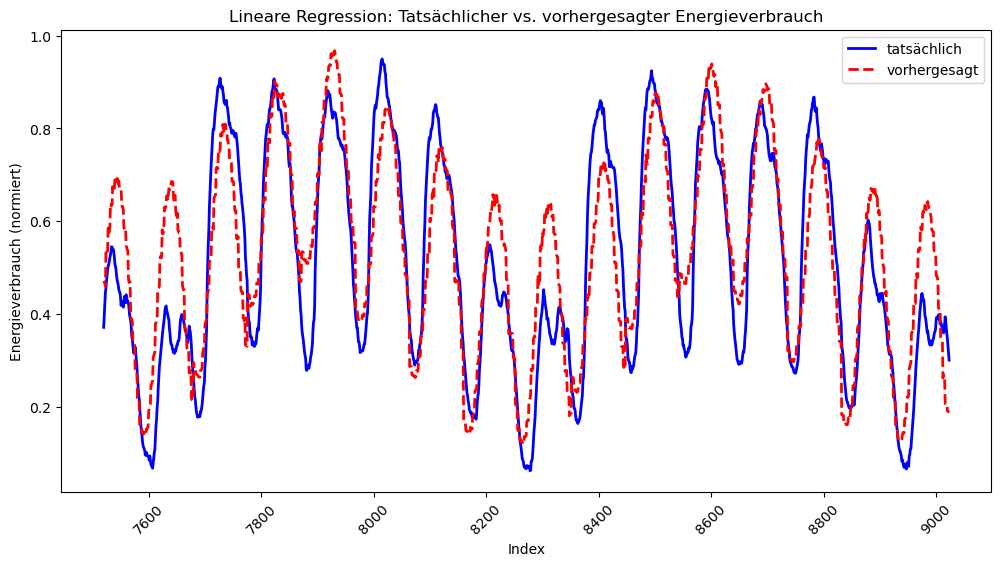

In [94]:


# Listen zur Speicherung der Mean Squared Error und R^2 Werte Werte
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
lr_model = LinearRegression()

# Startzeit messen
start_time = time.time()

# Iteration über die Aufteilungen in Train und Test Daten
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    lr_model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred_lr = lr_model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred_lr)
    r2 = r2_score(y_test, y_pred_lr)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Endzeit messen
end_time = time.time()

# Zeitdifferenz berechnen
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Code for plotting
xaxis_data = y_test.index
first_label = "tatsächlich"
second_label = "vorhergesagt"
title = "Lineare Regression: Tatsächlicher vs. vorhergesagter Energieverbrauch"
xaxis = "Index"
yaxis = "Energieverbrauch (normiert)"

lin_2024 = plot_two_lines(y_test.values, y_pred_lr, xaxis_data, first_label, second_label, title, xaxis, yaxis)
lin_2024.show()


### 3.1.3 Vorhersage der EM 2024

<Figure size 1000x500 with 0 Axes>

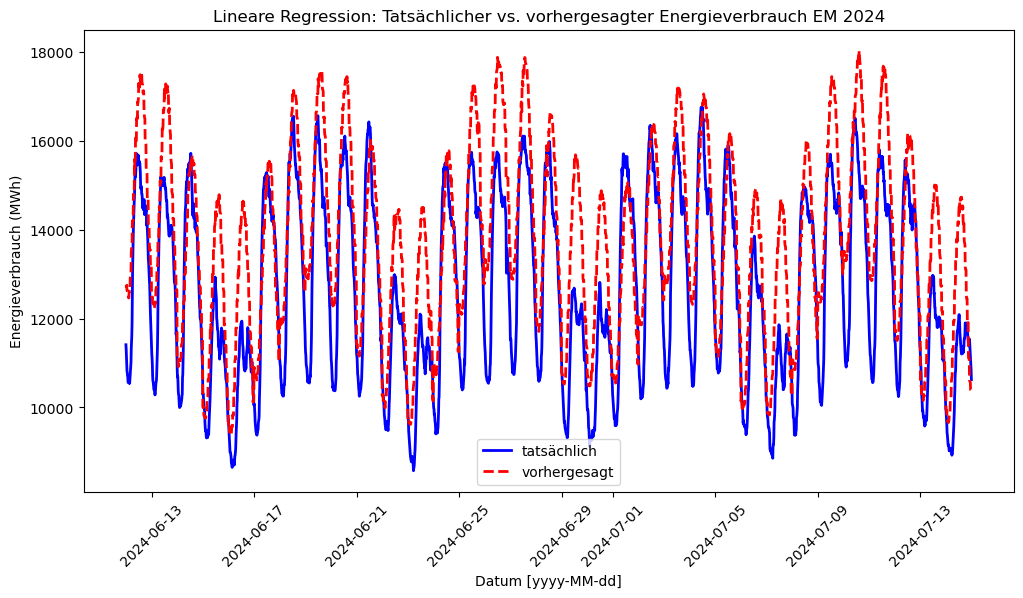

In [95]:
data_2024 = df_normalized_cyclic_new[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Fülle fehlende Werte in den neuen Daten auf
data_2024 = data_2024.fillna(0)

# Verwende das bereits trainierte Modell für Vorhersagen
y_pred_lr = lr_model.predict(data_2024)

# Zeige die Vorhersagen an
plt.figure(figsize=(10, 5))

#Gegenüberstellung der u simulierten Daten mit dem tatsächlichen Verbrauch während der EM 2024

y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']

y_2024_new_reshaped = y_2024.values.reshape(-1, 1)

# Erstelle einen neuen MinMaxScaler für das Target FEATURE
scaler_target = MinMaxScaler()

scaler_target.fit(df_reduced[['Gesamt (Netzlast) [MWh] Originalauflösungen']])

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_2024_original = scaler_target.inverse_transform(y_2024_new_reshaped)

# Prozess für vorhergesagte Daten wiederholen
y_pred_lr_reshaped = y_pred_lr.reshape(-1, 1)

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_pred_original = scaler_target.inverse_transform(y_pred_lr_reshaped)

# Visualisierung des simulierten Verbrauchs
xaxis_data = df_2024_datetime
first_label = "tatsächlich"
second_label = "vorhergesagt"
title = "Lineare Regression: Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024"
xaxis = "Datum [yyyy-MM-dd]"
yaxis = "Energieverbrauch (MWh)"

lin_2024 = plot_two_lines(y_2024_original, y_pred_original, xaxis_data, first_label, second_label, title, xaxis, yaxis)

lin_2024.show()

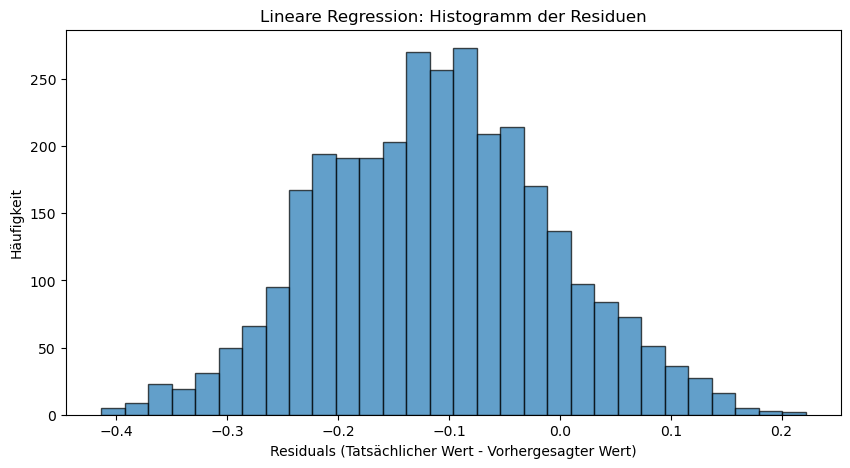

In [96]:
# Berechnung der Residuen
residuals = y_2024.values - y_pred_lr

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Lineare Regression: Histogramm der Residuen')
plt.show()


## 3.2 Random Forest

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein Random Forest Regressor Modell und bewertet es mit den Metriken MSE und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

### 3.2.1 Modellierung und Bewertung


Train index: 1503, Test index: 3007
Mean Squared Error: 0.0011854742225908901
R^2 Score: 0.9811606490365641
Train index: 3007, Test index: 4511
Mean Squared Error: 0.0020023131099030055
R^2 Score: 0.968570143197497
Train index: 4511, Test index: 6015
Mean Squared Error: 0.0012091867002812075
R^2 Score: 0.9805617641790481
Train index: 6015, Test index: 7519
Mean Squared Error: 0.002683350051688956
R^2 Score: 0.9467007111284892
Train index: 7519, Test index: 9023
Mean Squared Error: 0.0014537775697907904
R^2 Score: 0.9739334343638133
Average Mean Squared Error: 0.0017068203308509698
Average R^2 Score: 0.9701853403810823
Execution time: 24.79380202293396 seconds


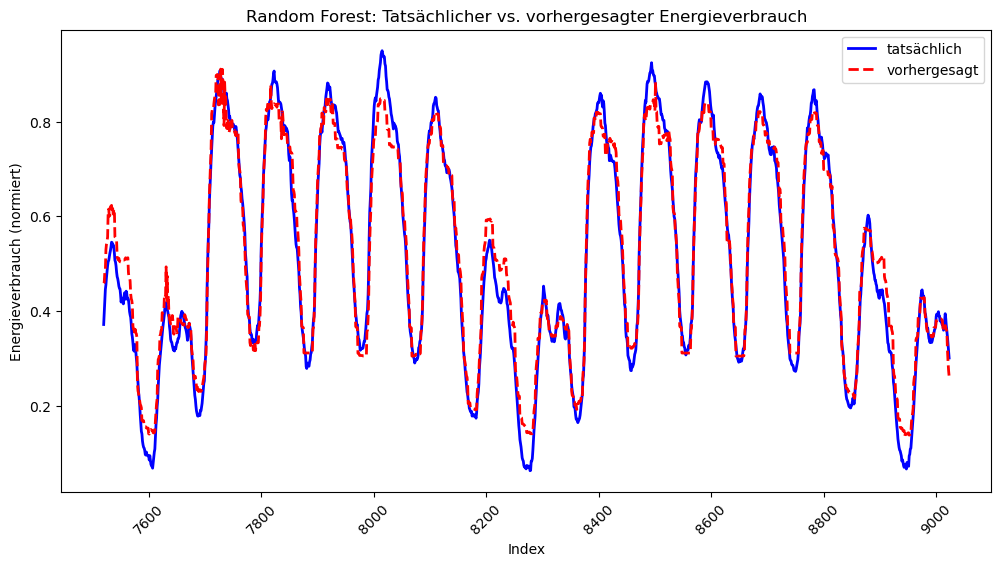

In [97]:

# Listen zur Speicherung der Fehlermaße
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # Aufteilen der Daten in 5 Teile

# Random Forest Modell initialisieren
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,             # Begrenzung der maximalen Tiefe der Bäume
    min_samples_split=5,     # Mindestanzahl von Proben, um einen Knoten zu teilen
    min_samples_leaf=1,       # Mindestanzahl von Proben in einem Blatt
    max_features='auto'       # Anzahl der zu betrachtenden Features pro Split
)

# Startzeit messen
start_time = time.time()

# Iteration über die Aufteilungen
for train_index, test_index in tscv.split(X):
    # Aufteilen der Features und Zielvariable in Trainings- und Testdaten
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    rf_model.fit(X_train, y_train)
    
    # Vorhersage durch Random Forest
    y_pred_rf = rf_model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred_rf)
    r2 = r2_score(y_test, y_pred_rf)
    
    # Speichern der Fehlermaße
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Endzeit messen
end_time = time.time()

# Zeitdifferenz berechnen
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Code for plotting
xaxis_data = y_test.index
first_label = "tatsächlich"
second_label = "vorhergesagt"
title = "Random Forest: Tatsächlicher vs. vorhergesagter Energieverbrauch"
xaxis = "Index"
yaxis = "Energieverbrauch (normiert)"

rf_2024 = plot_two_lines(y_test.values, y_pred_rf, xaxis_data, first_label, second_label, title, xaxis, yaxis)
rf_2024.show()


### 3.2.2 Vergleich von Training- und Testfehlern

In [29]:
# Initialisiere Listen, um die MSE- und R²-Werte für das Training und Testen zu speichern
mse_train_scores = []
r2_train_scores = []
mse_scores = []
r2_scores = []

# Führe die TimeSeriesSplit-Kreuzvalidierung durch
for train_index, test_index in tscv.split(X):
    # Teile die Daten in Trainings- und Testdaten auf
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Trainiere das Random Forest Modell
    rf_model.fit(X_train, y_train)
    
    # Vorhersagen für Trainings- und Testdaten
    y_pred_train = rf_model.predict(X_train)
    y_pred_rf = rf_model.predict(X_test)
    
    # Berechne den MSE für das Training und Testen
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_rf)
    
    # Berechne den R²-Score für das Training und Testen
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_rf)
    
    # Füge die berechneten Werte zu den Listen hinzu
    mse_train_scores.append(mse_train)
    r2_train_scores.append(r2_train)
    mse_scores.append(mse_test)
    r2_scores.append(r2_test)
    
    # Gib die MSE- und R²-Werte für das Training und Testen 


Train MSE: 7.17720673364784e-05, Test MSE: 0.0011854742225908901
Train R²: 0.9988259592999988, Test R²: 0.9811606490365641
Train MSE: 8.812860223404739e-05, Test MSE: 0.0020023131099030055
Train R²: 0.9985793881693164, Test R²: 0.968570143197497
Train MSE: 0.000133941466724565, Test MSE: 0.0012091867002812075
Train R²: 0.9978840647852342, Test R²: 0.9805617641790481
Train MSE: 0.0001691660069137799, Test MSE: 0.002683350051688956
Train R²: 0.9973192300863953, Test R²: 0.9467007111284892
Train MSE: 0.0002605400810582485, Test MSE: 0.0014537775697907904
Train R²: 0.9956973623708292, Test R²: 0.9739334343638133


### 3.2.3 Learning Curves

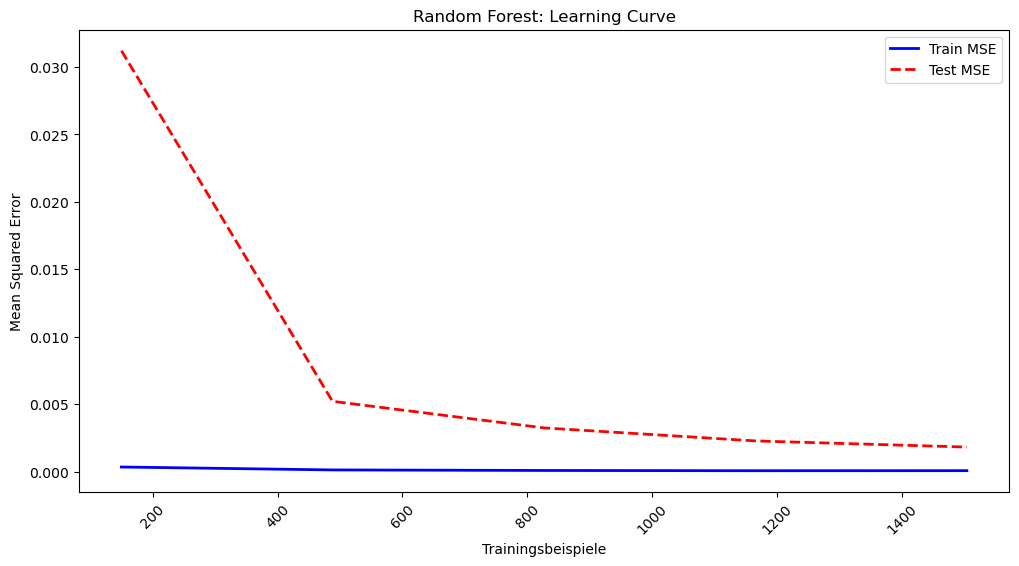

In [30]:
# Berechne die Lernkurve für das Random Forest Modell
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Berechne den Mittelwert der Trainings- und Testfehler (MSE) für jede Trainingsgröße
train_scores_mean = -train_scores.mean(axis=1)  # Umwandlung von negativen MSE in positive MSE
test_scores_mean = -test_scores.mean(axis=1)    # Umwandlung von negativen MSE in positive MSE

# Daten für die x-Achse (Anzahl der Trainingsbeispiele)
xaxis_data = train_sizes

# Bezeichne die Linien im Plot
first_label = "Train MSE"  # Label für die Trainings-MSE-Linie
second_label = "Test MSE"  # Label für die Test-MSE-Linie

# Titel und Achsenbeschriftungen für den Plot
title = "Random Forest: Learning Curve"
xaxis = "Trainingsbeispiele"  # Beschriftung der x-Achse
yaxis = "Mean Squared Error"   # Beschriftung der y-Achse

# Erstelle den Plot mit den Lernkurven
rf_curve_2024 = plot_two_lines(train_scores_mean, test_scores_mean, xaxis_data, first_label, second_label, title, xaxis, yaxis)

# Zeige den Plot an
rf_curve_2024.show()


### 3.2.4 Hyperparameter Tuning

- Der Code trainiert ein Random Forest Regressionsmodell auf einer Zeitreihen-Dataset.
- Die Daten werden in 5 Splits aufgeteilt, wobei jeweils ein Teil als Testdaten und der Rest als Trainingsdaten genutzt wird.
- Das Modell wird für jeden Split trainiert und bewertet (mittels MSE und R²).
- Durchschnittliche Fehlermaße werden berechnet und die Vorhersagen des letzten Splits visualisiert.

In [35]:
# Definiere den Parameterbereich für die RandomizedSearchCV
param_grid = {
    'max_depth': [5, 10, 15],                  # Maximale Tiefe der Bäume
    'min_samples_split': [5, 10, 20],           # Minimale Anzahl an Proben, die benötigt werden, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 5],              # Minimale Anzahl an Proben, die in einem Blatt vorhanden sein müssen
    'max_features': ['auto', 'sqrt', 'log2'],  # Anzahl der Merkmale, die bei der Suche nach dem besten Split berücksichtigt werden
    'n_estimators': [100, 200, 300]             # Anzahl der Bäume im Wald
}

# Initialisiere RandomizedSearchCV mit den oben definierten Parametern
random_search = RandomizedSearchCV(
    estimator=rf_model,                  # Das Modell, das optimiert werden soll
    param_distributions=param_grid,     # Der Bereich der zu testenden Hyperparameter
    n_iter=50,                          # Anzahl der zufälligen Kombinationen von Hyperparametern, die getestet werden
    cv=3,                               # Anzahl der Folds für die Kreuzvalidierung
    n_jobs=-1,                          # Anzahl der gleichzeitig auszuführenden Jobs (alle verfügbaren Kerne verwenden)
    verbose=2,                          # Detailgrad der Ausgaben
    random_state=42                     # Zufallszahlengenerator für Reproduzierbarkeit
)

# Trainiere das Modell mit der RandomizedSearchCV
random_search.fit(X, y)

# Gebe die besten gefundenen Hyperparameter aus
print("Beste Hyperparameter: ", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Beste Hyperparameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10}


### 3.2.3 Vorhersage der EM 2024


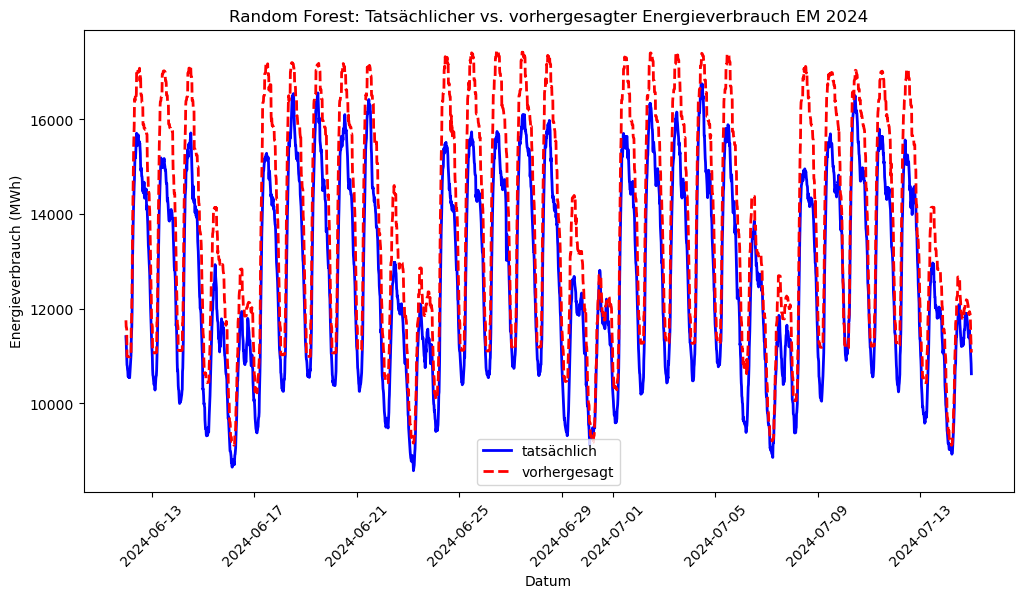

In [33]:
# Vorhersage des Verbrauchs während der EM 2024
y_pred_rf = rf_model.predict(data_2024)

#Auflösen der Normierung

y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']

y_2024_new_reshaped = y_2024.values.reshape(-1, 1)

# Erstelle einen neuen MinMaxScaler für das Target FEATURE
scaler_target = MinMaxScaler()

scaler_target.fit(df_reduced[['Gesamt (Netzlast) [MWh] Originalauflösungen']])

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_2024_original = scaler_target.inverse_transform(y_2024_new_reshaped)

# Prozess für vorhergesagte Daten wiederholen
y_pred_rf_reshaped = y_pred_rf.reshape(-1, 1)

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_pred_original = scaler_target.inverse_transform(y_pred_rf_reshaped)

xaxis_data = df_2024_datetime
first_label = "tatsächlich"
second_label = "vorhergesagt"
title = "Random Forest: Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024"
xaxis = "Datum Datum [yyyy-MM-dd]"
yaxis = "Energieverbrauch (MWh)"

rf_curve_2024 =plot_two_lines(y_2024_original, y_pred_original, xaxis_data, first_label, second_label, title, xaxis, yaxis)

rf_curve_2024.show()

Hier werden die Vorhersagen des trainierten Modells für neue Daten erstellt und visualisiert. Indem der Spielplan und die Wetterdaten gegeben und der Verbrauch mit dem trainierten Modell vorhergesagt wird.



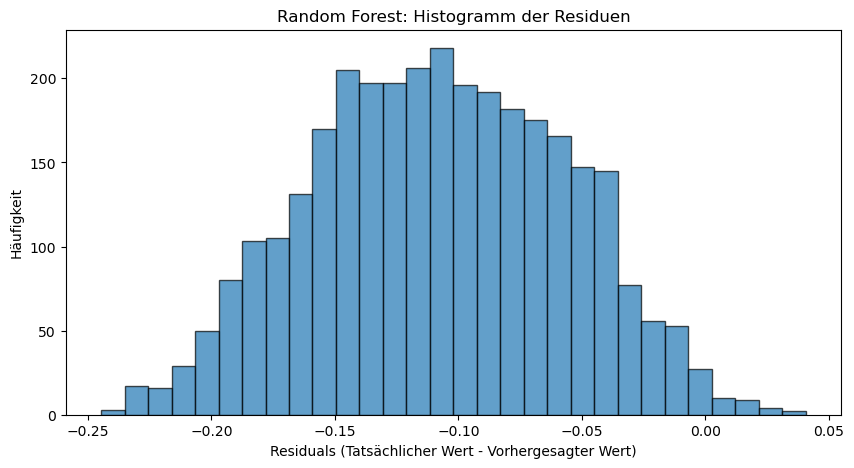

In [36]:

# Berechnung der Residuen
residuals = y_2024.values - y_pred_rf

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Random Forest: Histogramm der Residuen')
plt.show()


## 3.3 LSTM

Dieser Code benutzt LSTM für die Vorhersage der Stromverbrauchdaten. Hierfür werden folgende Schritte durchgeführt:
- Anpassung der Datentypen (64 bits zu 32 bits)
- Transformation der Daten in Sequenzen und Tensor
- Festlegung der Modellarchtitektur
- Modellierung und Ausgabe von Lernkurven
- Vorhersage des EM 2024 Stromverbrauchs

### 3.3.1 Datentypen für LSTM anpassen

In [98]:
# Boolean-Spalten in Ganzzahlen umwandeln (1 für True, 0 für False)
bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']
df_normalized_cyclic[bool_columns] = df_normalized_cyclic[bool_columns].astype(int)

# Float-Spalten in 32-Bit Fließkommazahlen umwandeln
float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']
df_normalized_cyclic[float_columns] = df_normalized_cyclic[float_columns].astype(np.float32)

# Integer-Spalten in 32-Bit Ganzzahlen umwandeln
int_columns = ['year', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos', "is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 
               'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']
df_normalized_cyclic[int_columns] = df_normalized_cyclic[int_columns].astype(np.int32)


### 3.3.2 Dataframe in Sequenzen und Tensor umwandeln

In [99]:
# Die Zielspalte definieren
target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Merkmale (Features) und Zielvariable (Target) trennen
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

# Länge der Sequenz für das LSTM definieren
sequence_length = 96

# Erstelle Sequenzen für die LSTM-Eingaben und -Ausgaben
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X für das LSTM-Modell: [Proben, Zeitstufen, Merkmale]
num_features = X_sequences.shape[2]  # Anzahl der Merkmale
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))


### 3.3.3 Festlegung der Modellarchitektur

In [100]:
layers = 32
epochs = 20
regularization = 0.001
dropout = 0.3
learning_rate = 0.0005
early_stopping = 5

### 3.3.4 Train und Test Split mit Validierung

C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 0.2672 - val_loss: 0.1996
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.1299 - val_loss: 0.1691
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.1049 - val_loss: 0.1521
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0907 - val_loss: 0.1277
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0747 - val_loss: 0.1086
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0658 - val_loss: 0.0960
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0579 - val_loss: 0.0838
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0521 - val_loss: 0.0783
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0460 - val_loss: 0.0726
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0422 - val_loss: 0.0712
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0383 - val_loss: 0.0674
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0

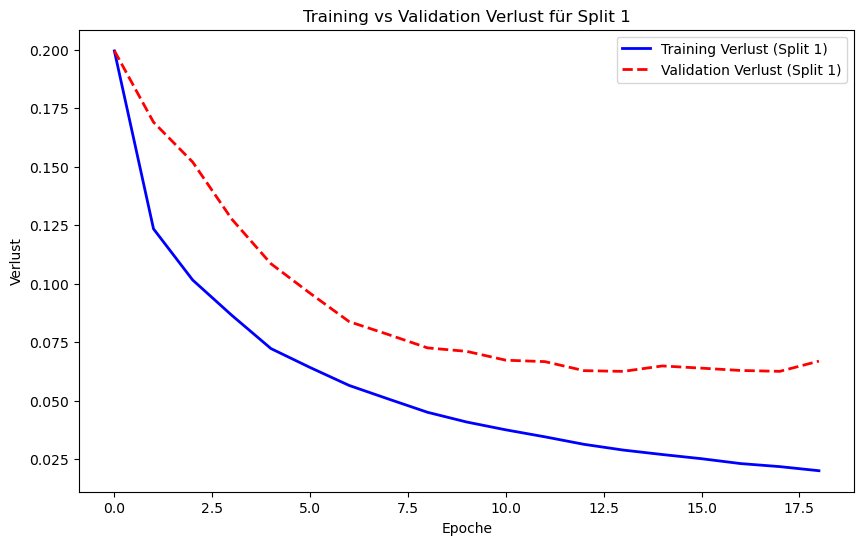

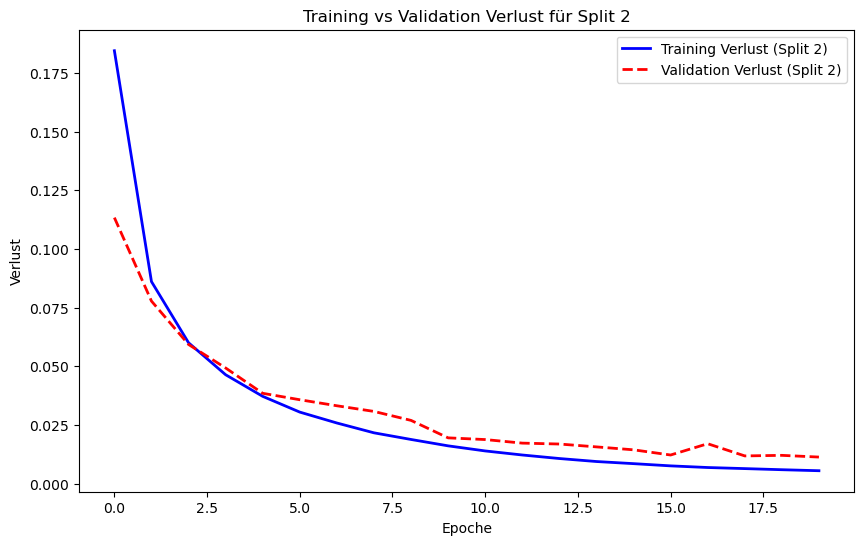

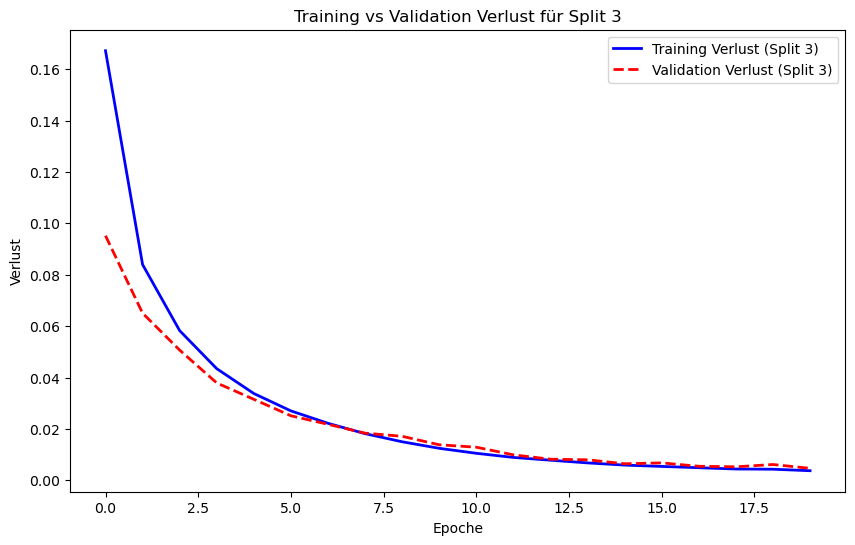

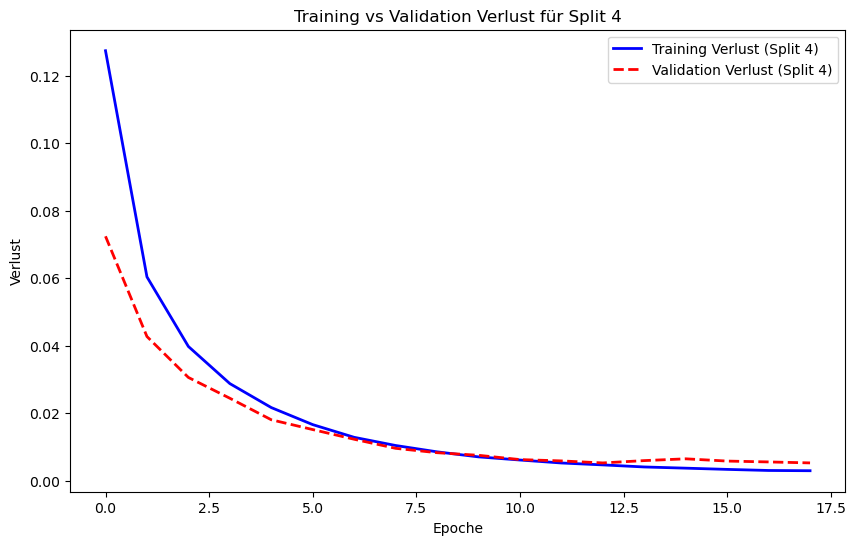

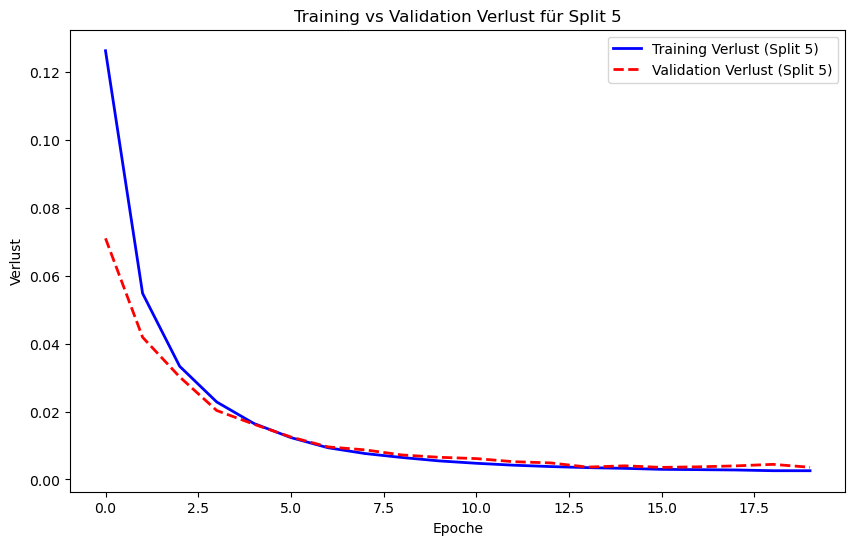

In [101]:


# Initialisiere TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Listen zum Speichern der Ergebnisse
split_results = []
train_losses_per_split = []
val_losses_per_split = []

# Startzeit messen
start_time = time.time()

# Schleife über die Splits für Cross-Validation
for train_index, test_index in tscv.split(X_sequences):

    # Teile die Daten in Trainings- und Testsets auf
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]

    # Trainiere das LSTM-Modell und erhalte die Historie
    history, model = lstm_model(X_train, X_test, y_train, y_test, layers, epochs, regularization, dropout, learning_rate, early_stopping)
    
    # Bewerte das Modell und speichere die Verluste
    train_losses_per_split.append(history.history['loss'])
    val_losses_per_split.append(history.history['val_loss'])
    
    # Berechne den Verlust für das Testset
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Endzeit messen
end_time = time.time()

# Berechne den durchschnittlichen Verlust über alle Splits
average_loss = np.mean(split_results)
print(f'Durchschnittlicher Validierungsverlust über alle Splits: {average_loss}')

# Zeitdifferenz berechnen
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Plotte die Trainings- und Validierungsverluste für jeden Split
for i in range(len(train_losses_per_split)):

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_per_split[i], label=f'Training Verlust (Split {i+1})', color='blue', linewidth=2)
    plt.plot(val_losses_per_split[i], label=f'Validation Verlust (Split {i+1})', color='red', linewidth=2, linestyle='--')
    plt.title(f'Training vs Validation Verlust für Split {i+1}')
    plt.xlabel('Epoche')
    plt.ylabel('Verlust')
    plt.legend()
    plt.show()


### 3.3.5 Finales Model

In [41]:
# Annahme, dass das Modell gut abgeschnitten hat, nun auf dem gesamten Datensatz trainieren (außer dem letzten Testset)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]

# Trainiere das LSTM-Modell auf den finalen Trainings- und Testdaten
lstm_final, model_final = lstm_model(X_train_final, X_test_final, y_train_final, y_test_final, layers, epochs, regularization, dropout, learning_rate, early_stopping)

# Endgültige Bewertung des Modells
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Finaler Testverlust: {final_loss}')

# Vorhersage auf dem Testset
y_pred = model_final.predict(X_test_final)

# Berechne den R²-Score der Vorhersagen
r2 = r2_score(y_test_final, y_pred)
print(f'R²-Score: {r2}')


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.1459 - val_loss: 0.0571
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - loss: 0.0529 - val_loss: 0.0356
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: 0.0309 - val_loss: 0.0225
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0208 - val_loss: 0.0161
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - loss: 0.0149 - val_loss: 0.0123
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 12/20
402/402 ━━━━━━━━━━

Text(0, 0.5, 'Energieverbrauch (normiert)')

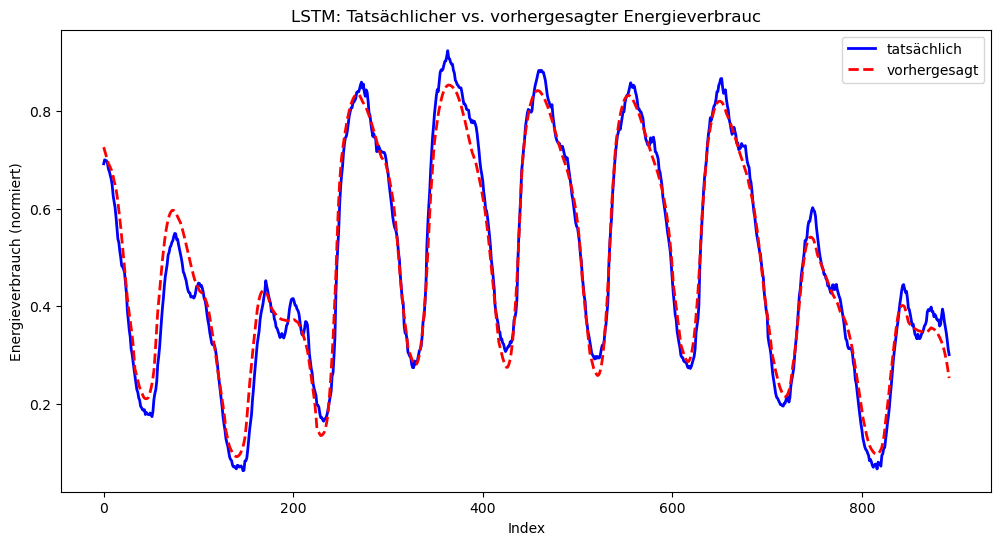

In [43]:
# Plottien tatsächliche vs vorhergesagten Werten
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='tatsächlich', color='blue', linewidth=2)
plt.plot(y_pred, label='vorhergesagt', color='red', linewidth=2, linestyle='--')
plt.title('LSTM: Tatsächlicher vs. vorhergesagter Energieverbrauc')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Energieverbrauch (normiert)')


### 3.3.6 Vorhersage der EM 2024 

- umwandeln in korrekte Datentypen
- Kompelieren des Tensors und Vorhersagen mit erstelltem Modell
- normierte Werte in ursprüngliche Skala umwandeln
- Plot des Ergebnisses und Histogramm der Residuen

In [44]:
# Boolean-Spalten in Integer konvertieren
bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[bool_columns] = df_normalized_cyclic_new[bool_columns].astype(int)
# Float-Spalten in float32 konvertieren
float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic_new[float_columns] = df_normalized_cyclic_new[float_columns].astype(np.float32)
# Integer-Spalten in int32 konvertieren
int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[int_columns] = df_normalized_cyclic_new[int_columns].astype(np.int32)

In [45]:
# Definiere die Zielspalte
target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Merkmale und Zielvariablen trennen
X = df_normalized_cyclic_new.drop(columns=[target_column])
y = df_normalized_cyclic_new[target_column]

# Setze die Sequenzlänge
sequence_length = 96

# Erstelle Sequenzen
X_sequences_em, y_sequences_em = create_sequences(X.values, y.values, sequence_length)

# Bestimme die Anzahl der Merkmale
num_features = X_sequences_em.shape[2]  # Anzahl der Merkmale

# Forme die Sequenzen für LSTM um: [samples, time steps, features]
X_sequences_em = X_sequences_em.reshape((X_sequences_em.shape[0], X_sequences_em.shape[1], num_features))

# Vorhersage für 2024 durchführen
y_pred_lstm_2024 = model_final.predict(X_sequences_em)

print("done")


X_sequences shape: (3072, 96, 27)
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
done


In [50]:

y_2024_seq_new_reshaped = y_sequences_em.reshape(-1, 1)

# Erstelle einen neuen MinMaxScaler für das Target FEATURE
scaler_target = MinMaxScaler()

scaler_target.fit(df_reduced[['Gesamt (Netzlast) [MWh] Originalauflösungen']])

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_sequence_lstm_original = scaler_target.inverse_transform(y_2024_seq_new_reshaped )

# Prozess für vorhergesagte Daten wiederholen
y_pred_lstm_reshaped = y_pred_lstm_2024.reshape(-1, 1)

# Durchführung der inversere Transfomation zur Auflösung der Normierung
y_pred_lstm_original = scaler_target.inverse_transform(y_pred_lstm_2024)


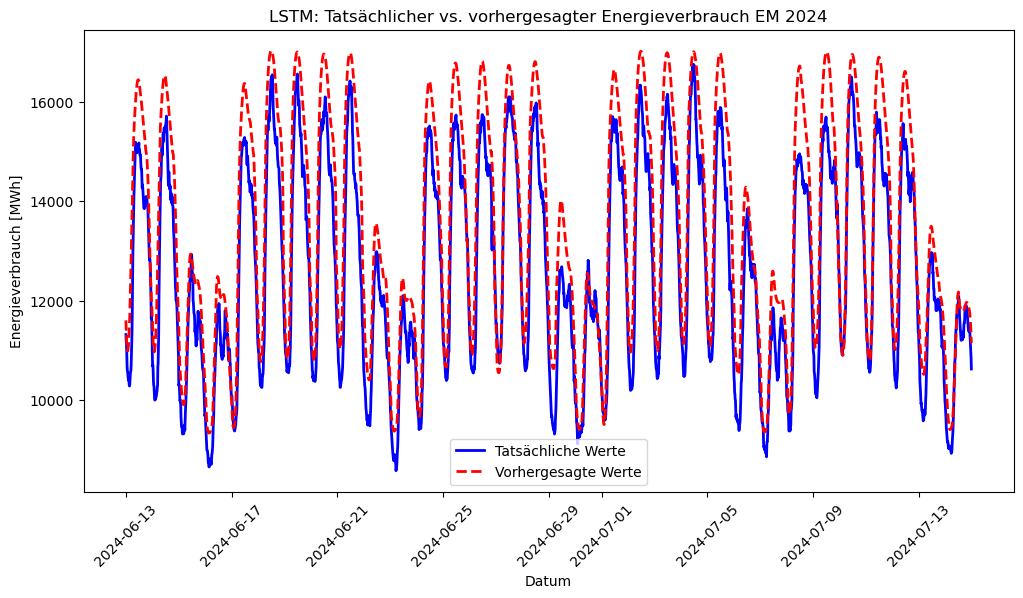

In [54]:
# Vorhersage des LSTM-Modells für 2024
first_data = y_sequences_em  # Tatsächliche Werte
second_data = y_pred_lstm_2024  # Vorhergesagte Werte

# x-Achsen-Daten (Datum) vorbereiten
xaxis_data = df_2024_datetime_trimmed = df_2024_datetime.iloc[96:]

# Labels und Titel für das Diagramm festlegen
first_label = "Tatsächliche Werte"
second_label = "Vorhergesagte Werte"
title = "LSTM: Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024"
xaxis = "Datum"
yaxis = "Energieverbrauch [MWh]"

# Diagramm erstellen und anzeigen
em_plot = plot_two_lines(first_data, second_data, xaxis_data, first_label, second_label, title, xaxis, yaxis)
em_plot.show()


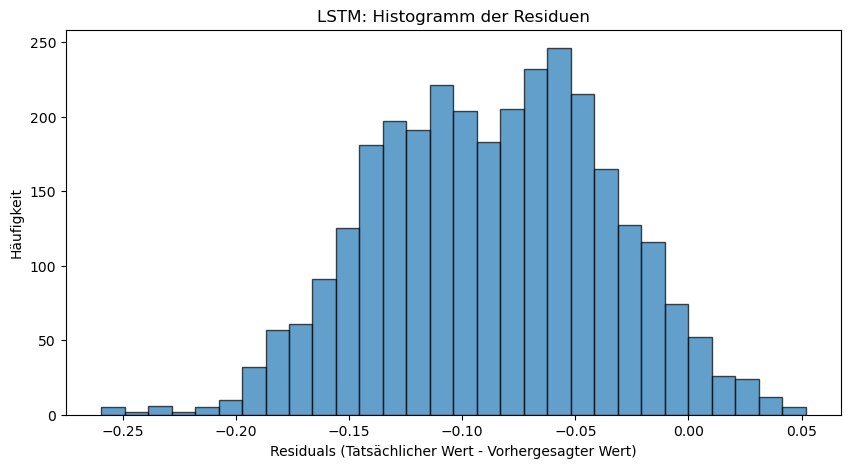

In [57]:
# Berechnung der Residuen
residuals_lstm = y_2024_seq_new_reshaped  - y_pred_lstm_reshaped

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals_lstm, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('LSTM: Histogramm der Residuen')
plt.show()
